In [1]:
###   BIO-322 Miniproject – Decoding Neural Activity   ###

# 0. Setup
# Imports, random seeds and global configuration.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

In [29]:
# 1. Data inspection
# Load the training data, inspect basic structure, missing values, and class balance. 

In [30]:
df = pd.read_csv("train.csv")
df.head()
df.info()
df.describe()

print("Class balance (TRIAL_TYPE):")
print(df["TRIAL_TYPE"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Columns: 1383 entries, session_id to TRIAL_TYPE
dtypes: float64(1380), int64(1), object(2)
memory usage: 46.5+ MB
Class balance (TRIAL_TYPE):
TRIAL_TYPE
NOGO W- nolick       0.199682
GO W- nolick         0.184479
NOGO W+ nolick       0.179941
no tone W+ nolick    0.165872
GO W+ lick           0.161334
GO W+ nolick         0.038348
no tone W+ lick      0.034037
NOGO W+ lick         0.019968
GO W- lick           0.015657
NOGO W- lick         0.000681
Name: proportion, dtype: float64


In [31]:
# 2. Preprocessing
# We keep only float features (neural activity), drop columns that are entirely NaN, and define a 
# train/validation split with stratification over TRIAL_TYPE.

In [32]:
RANDOM_STATE = 0

# Select only the neural activity features
X = df.select_dtypes(include=["float64"])

# Drop features that are NaN for ALL trials (completely useless columns)
X = X.dropna(axis=1, how="all")

# Target labels: trial type (what happened in the trial)
y = df["TRIAL_TYPE"]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,          # 20% of data for validation
    random_state=RANDOM_STATE,
    stratify=y              # keep class proportions the same in train/val
)

X_train.shape, X_val.shape

((3525, 1350), (882, 1350))

In [33]:
# 3. Linear baseline - Logistic Regression

# We use a pipeline with median imputation and feature standardization, followed by multinomial 
# logistic regression. This serves as our linear baseline.

Validation accuracy (Logistic Regression): 0.6303854875283447


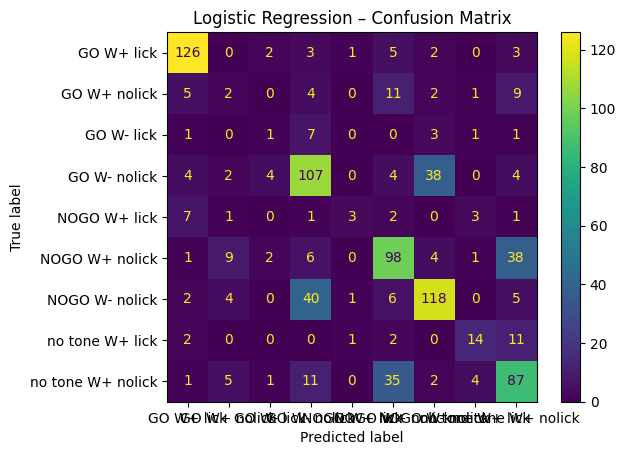

                   precision    recall  f1-score   support

       GO W+ lick       0.85      0.89      0.87       142
     GO W+ nolick       0.09      0.06      0.07        34
       GO W- lick       0.10      0.07      0.08        14
     GO W- nolick       0.60      0.66      0.63       163
     NOGO W+ lick       0.50      0.17      0.25        18
   NOGO W+ nolick       0.60      0.62      0.61       159
   NOGO W- nolick       0.70      0.67      0.68       176
  no tone W+ lick       0.58      0.47      0.52        30
no tone W+ nolick       0.55      0.60      0.57       146

         accuracy                           0.63       882
        macro avg       0.51      0.47      0.48       882
     weighted avg       0.62      0.63      0.62       882



{'LogisticRegression': 0.6303854875283447}

In [34]:
clf = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(max_iter=3000, n_jobs=-1, random_state=0)
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
lin_acc = clf.score(X_val, y_val)
print("Validation accuracy (Logistic Regression):", lin_acc)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

print(classification_report(y_val, y_pred))

# Store results for later comparison
results = {"LogisticRegression": lin_acc}
results

In [35]:
# 4.1. Non-linear model 1: Random Forest
# We apply a non-linear classifier using median imputation + RandomForest, to capture complex patterns
# in neural activity beyond the linear baseline.

Validation accuracy (Random Forest): 0.7142857142857143


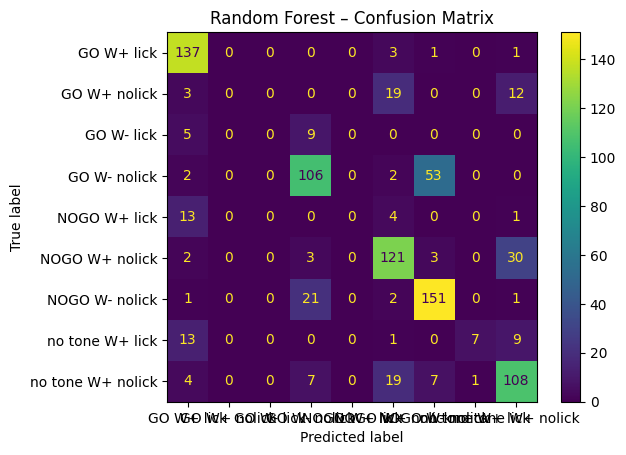

                   precision    recall  f1-score   support

       GO W+ lick       0.76      0.96      0.85       142
     GO W+ nolick       1.00      0.00      0.00        34
       GO W- lick       1.00      0.00      0.00        14
     GO W- nolick       0.73      0.65      0.69       163
     NOGO W+ lick       1.00      0.00      0.00        18
   NOGO W+ nolick       0.71      0.76      0.73       159
   NOGO W- nolick       0.70      0.86      0.77       176
  no tone W+ lick       0.88      0.23      0.37        30
no tone W+ nolick       0.67      0.74      0.70       146

         accuracy                           0.71       882
        macro avg       0.83      0.47      0.46       882
     weighted avg       0.74      0.71      0.68       882



{'LogisticRegression': 0.6303854875283447, 'RandomForest': 0.7142857142857143}

In [36]:
# Define the Random Forest pipeline
rf_clf = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=0
    )
)

# Train it
rf_clf.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_clf.predict(X_val)

# Compute accuracy
rf_acc = accuracy_score(y_val, y_pred_rf)
print("Validation accuracy (Random Forest):", rf_acc)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rf)
plt.title("Random Forest – Confusion Matrix")
plt.show()

print(classification_report(y_val, y_pred_rf, zero_division=1))

# Add to results dict
results["RandomForest"] = rf_acc
results

In [37]:
# 4.2. Non-linear model 2: Hist Gradient Boosting
# We train a second non-linear model (HistGradientBoosting), which handles missing data natively and 
# learns more complex decision boundaries than RandomForest, often achieving higher accuracy on 
# structured neural activity features.

Validation accuracy (HistGradientBoosting): 0.7380952380952381


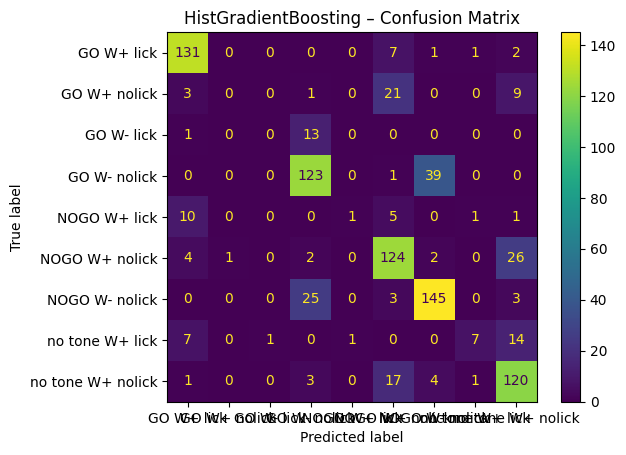

                   precision    recall  f1-score   support

       GO W+ lick       0.83      0.92      0.88       142
     GO W+ nolick       0.00      0.00      0.00        34
       GO W- lick       0.00      0.00      0.00        14
     GO W- nolick       0.74      0.75      0.75       163
     NOGO W+ lick       0.50      0.06      0.10        18
   NOGO W+ nolick       0.70      0.78      0.74       159
   NOGO W- nolick       0.76      0.82      0.79       176
  no tone W+ lick       0.70      0.23      0.35        30
no tone W+ nolick       0.69      0.82      0.75       146

         accuracy                           0.74       882
        macro avg       0.55      0.49      0.48       882
     weighted avg       0.70      0.74      0.71       882

Results so far: {'LogisticRegression': 0.6303854875283447, 'RandomForest': 0.7142857142857143, 'HistGradientBoosting': 0.7380952380952381}


In [38]:
hgb_clf = HistGradientBoostingClassifier(
    max_depth=8,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

hgb_clf.fit(X_train, y_train)
y_pred_hgb = hgb_clf.predict(X_val)

hgb_acc = accuracy_score(y_val, y_pred_hgb)
print("Validation accuracy (HistGradientBoosting):", hgb_acc)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_hgb)
plt.title("HistGradientBoosting – Confusion Matrix")
plt.show()

print(classification_report(y_val, y_pred_hgb))

try:
    results
except NameError:
    results = {}

results["HistGradientBoosting"] = hgb_acc
print("Results so far:", results)

In [40]:
# 5. Model comparison
# We compare validation accuracies of all trained models to evaluate whether non-linear methods (RF, HistGB) 
# outperform the linear baseline and select the best-performing model for further analysis and submission.

Validation accuracies:
LogisticRegression: 0.630
RandomForest: 0.714
HistGradientBoosting: 0.738


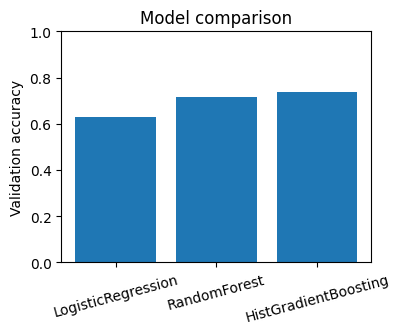

In [41]:
print("Validation accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.3f}")

plt.figure(figsize=(4,3))
plt.bar(results.keys(), results.values())
plt.ylabel("Validation accuracy")
plt.title("Model comparison")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()